# Deepwalk performance on reduced hetionet

read each feature set and test set in linear order

calculate the roc values and save


after all done:
    draw graph

In [1]:
import pandas as pd
import numpy as np

from tqdm import tqdm

from scipy import interp
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import precision_recall_curve

from sklearn.linear_model import LogisticRegression

In [2]:
%matplotlib inline

---

In [3]:
def add_features(df, features):
    return (df
        .merge(
            features, how="inner", left_on="chemical_uid", right_on="uid"
        )
        .drop("uid", axis=1)
        .merge(
            features, how="inner", left_on="disease_uid", right_on="uid"
        )
        .drop("uid", axis=1)
    )

def convolv_features(df, features, vecsize):
    reg = add_features(df, features)
    
    # do multiply and get rid of old features
    for i in range(vecsize):
        reg["conv{}".format(i)] = reg["f{}_x".format(i)] * reg["f{}_y".format(i)]

    reg = (reg
        .drop(
            ["f{}_x".format(i) for i in range(vecsize)], axis=1
        )
        .drop(
            ["f{}_y".format(i) for i in range(vecsize)], axis=1
        )
    )
        
    return reg

there are nodes in the holdout dataset that did not have any embeddings generated for it. check to see if they had proper adjlists made

In [4]:
def eval_performance(K, vecsize):
    for idx in tqdm(range(K)):
        train = pd.read_csv("data/train/train_{}.tsv".format(idx), sep='\t')
        holdout = pd.read_csv("data/holdout/holdout_{}.tsv".format(idx), sep='\t')

        features = pd.read_csv(
            "data/embeddings/embedding_{}.txt".format(idx),
            sep=" ", skiprows=1,
            names=["uid"] + ["f{}".format(i) for i in range(vecsize)]
        )

        tmp = convolv_features(train, features, vecsize)

        feat_cols = ["conv{}".format(j) for j in range(vecsize)]
        regmodel = LogisticRegression(C=1e9).fit(tmp[feat_cols], tmp["etype"])

        # test on holdout
        test = convolv_features(
            holdout.drop("etype", axis=1),
            features, vecsize
        )

        # add in predictions
        ans = test.assign(
            predval = lambda df: regmodel.predict_proba(df[feat_cols])[:, 1]
        )
        
        yield (ans
            [["chemical_uid", "disease_uid", "predval"]]
            .merge(
                holdout[["chemical_uid", "disease_uid", "etype"]],
                how="inner", on=["chemical_uid", "disease_uid"]
            )
            .sort_values("predval", ascending=False)
            .reset_index(drop=True)
        )

100%|██████████| 10/10 [01:19<00:00,  7.94s/it]


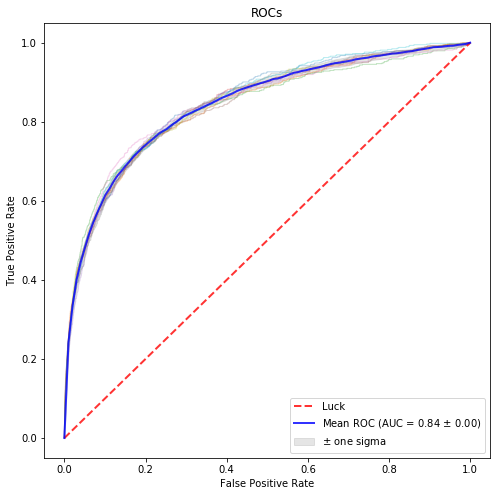

In [5]:
K = 10
vecsize = 128

tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)

plt.figure(figsize=(8, 8))

for res in eval_performance(K, vecsize):
    fpr, tpr, thresh = roc_curve(res["etype"], res["predval"])

    tprs.append(interp(mean_fpr, fpr, tpr))
    tprs[-1][0] = 0
    auc_val = auc(fpr, tpr)
    aucs.append(auc_val)

    plt.plot(fpr, tpr, lw=1, alpha=0.3)
    
# ---------------    
    
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Luck', alpha=0.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)

plt.plot(
    mean_fpr, mean_tpr, color='b',
    label="Mean ROC (AUC = %0.2f $\pm$ %0.2f)" % (mean_auc, std_auc),
    lw=2, alpha=0.8
)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
plt.fill_between(
    mean_fpr, tprs_lower, tprs_upper, color='grey',
    alpha=0.2, label="$\pm$ one sigma"
)

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title("ROCs")
          
plt.legend(loc="lower right")
plt.show()

In [6]:
aucs

[0.84909596099592444,
 0.83855213630893022,
 0.83786380087420564,
 0.844787276986388,
 0.84129711848540012,
 0.8382755715628929,
 0.84418537374132208,
 0.84286533336429381,
 0.84492337041601306,
 0.850843410169835]

---

## Precision recall curves

100%|██████████| 10/10 [01:18<00:00,  7.83s/it]


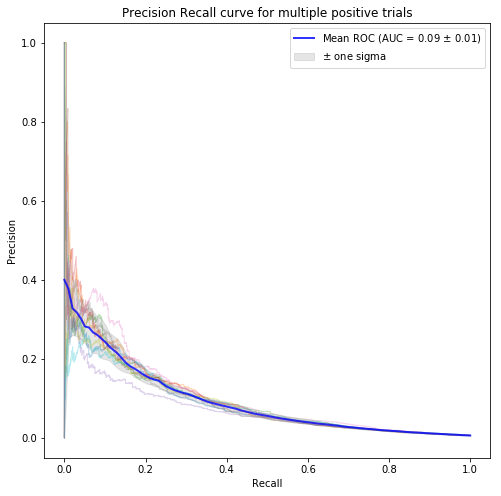

In [7]:
K = 10
vecsize = 128

precision_vals = []
aucs = []
mean_recall = np.linspace(0, 1, 100)

plt.figure(figsize=(8, 8))

for res in eval_performance(K, vecsize):
    precision, recall, thresh = precision_recall_curve(res["etype"], res["predval"])
    
    # x value has to be increasing
    precision_vals.append(
        interp(mean_recall, recall[::-1], precision[::-1])
    )
    
    auc_val = auc(recall, precision)
    aucs.append(auc_val)
    
    plt.plot(recall, precision, lw=1, alpha=0.3)
    
# ---------------    

mean_precision = np.mean(precision_vals, axis=0)

mean_auc = auc(mean_recall, mean_precision)
std_auc = np.std(aucs)

plt.plot(
    mean_recall, mean_precision, color='b',
    label="Mean ROC (AUC = %0.2f $\pm$ %0.2f)" % (mean_auc, std_auc),
    lw=2, alpha=0.8
)

std_precision = np.std(precision_vals, axis=0)
precision_upper = np.minimum(mean_precision + std_precision, 1)
precision_lower = np.maximum(mean_precision - std_precision, 0)

plt.fill_between(
    mean_recall, precision_lower, precision_upper,
    color='grey', alpha=0.2, label="$\pm$ one sigma"
)

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision Recall curve for multiple positive trials")
          
plt.legend(loc="upper right")
plt.show()

In [8]:
aucs

[0.084718331335648489,
 0.1021000203901388,
 0.095840166258085335,
 0.10023496870287188,
 0.075977804136410393,
 0.092772614980009965,
 0.1065782483583583,
 0.09061612601157179,
 0.088808759172617477,
 0.085362689171754977]